In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-science-bowl-2018/stage1_test.zip
/kaggle/input/data-science-bowl-2018/stage1_sample_submission.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_sample_submission_final.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_train.zip
/kaggle/input/data-science-bowl-2018/stage1_train_labels.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_solution.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_test_final.zip


In [2]:
import tensorflow as tf
import random
import warnings
warnings.filterwarnings('ignore')

2024-06-27 16:29:53.225422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 16:29:53.225561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 16:29:53.416304: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from zipfile import ZipFile
with ZipFile("../input/data-science-bowl-2018/stage1_train.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_train")
    
with ZipFile("../input/data-science-bowl-2018/stage1_test.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_test")

In [4]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

In [5]:
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    y[n] = mask 

Resizing training images and masks


100%|██████████| 670/670 [05:33<00:00,  2.01it/s]


In [7]:
# test images
test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    test_images[n] = img

print('Done!')

Resizing test images


100%|██████████| 65/65 [00:01<00:00, 37.44it/s]

Done!


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

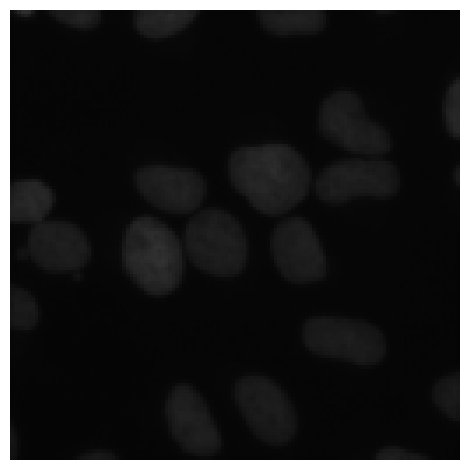

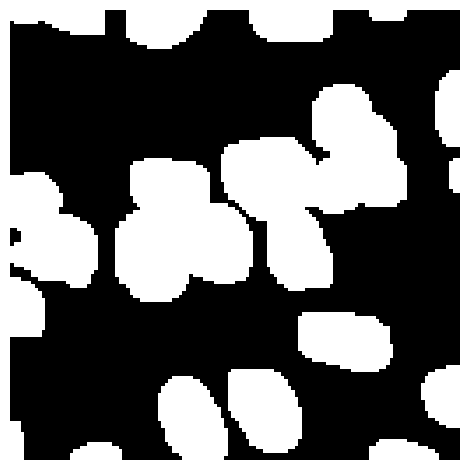

In [9]:
image_x = random.randint(0, len(X_train))
plt.axis("off")
imshow(X_train[image_x])
plt.show()
plt.axis("off")
imshow(np.squeeze(y_train[image_x]))
plt.show()

In [10]:
num_classes = 1

## MODEL ##

In [11]:
inputs=tf.keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
s=tf.keras.layers.Lambda(lambda x:x/255)(inputs)

c1= tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1=tf.keras.layers.Dropout(0.1)(c1)
c1= tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1= tf.keras.layers.MaxPooling2D(2,2)(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
checkpointer= tf.keras.callbacks.ModelCheckpoint('Model_for_Nuclei.keras',verbose=1,save_best_only=True)

In [13]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results=model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6603 - loss: 0.6568 - val_accuracy: 0.7257 - val_loss: 0.4872
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7662 - loss: 0.3785 - val_accuracy: 0.7406 - val_loss: 0.3378
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8324 - loss: 0.2825 - val_accuracy: 0.9203 - val_loss: 0.2211
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9322 - loss: 0.1900 - val_accuracy: 0.9311 - val_loss: 0.1785
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9430 - loss: 0.1519 - val_accuracy: 0.9474 - val_loss: 0.1458
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9486 - loss: 0.1358 - val_accuracy: 0.9508 - val_loss: 0.1307
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9515 - loss: 0.1297 - val_accuracy: 0.9524 - val_loss: 0.1257
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9543 - loss: 0.1216 - val_accuracy: 0.9548 - val_loss:

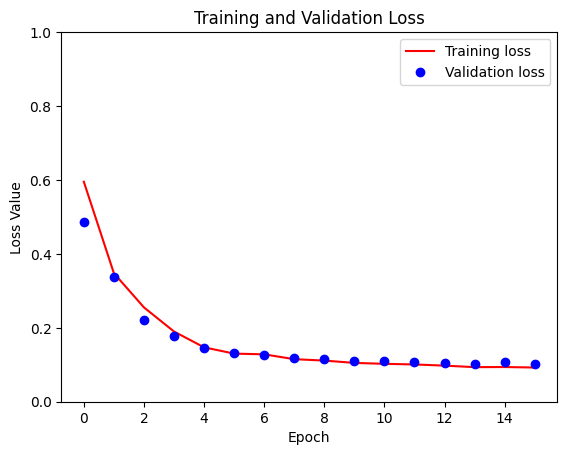

In [14]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

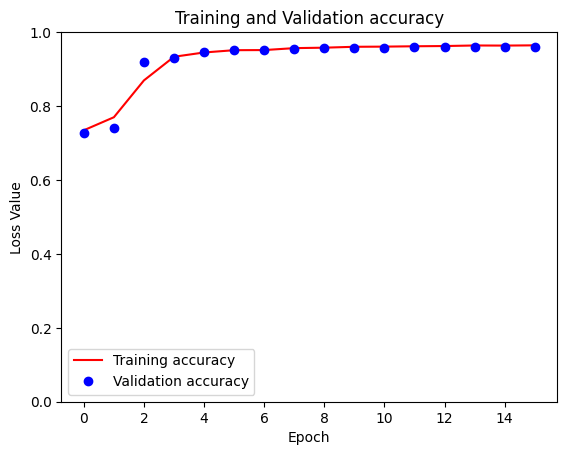

In [15]:
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

plt.figure()
plt.plot( accuracy, 'r', label='Training accuracy')
plt.plot( val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [16]:
import matplotlib.pyplot as plt
import tensorflow as tf

def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input image', 'True mask', 'Predicted mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


In [17]:
i = random.randint(0, len(X_test))
sample_image = X_test[i]
sample_mask = y_test[i]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


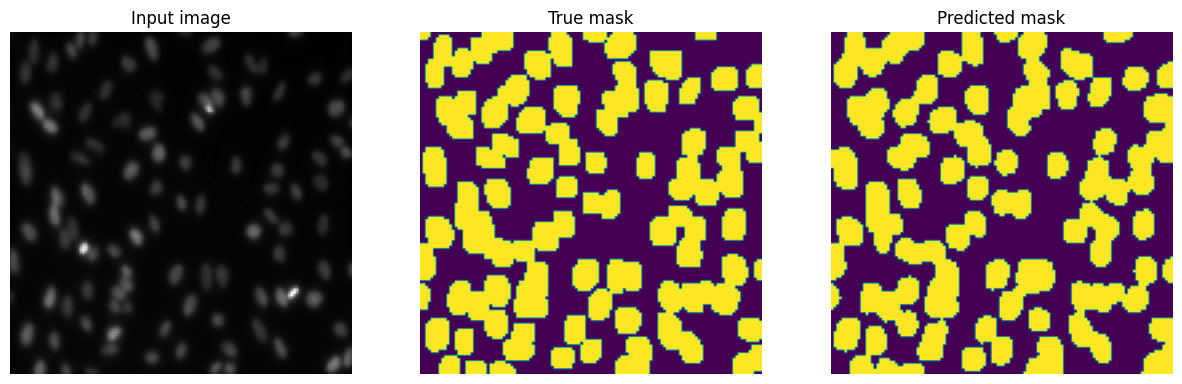

In [18]:
prediction = model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])